__We predict house prices for the Kaggle taining data set__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### Preparations

In [1]:
# imports
import pandas as pd
import numpy as np
import random as rnd

# utils
import os.path as path
import re
from __future__ import print_function # python2 compatible print(" ") 
import warnings

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from scipy import stats

from sklearn import metrics # this is to define the error used in the competition (log rmse)
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# setup
warnings.filterwarnings(action="ignore")

In [2]:
# Load data, set identifier and target
INPUT_FOLDER = "data"
# This column holds the to predicting variable
TARGET       = "SalePrice"
# This column identifies the target rows 

IDENTIFIER   = "Id"
def get_data(input_folder): 
    """ load the files train and test and return two variables with its content"""
    train = pd.read_csv(path.join(input_folder,"train.csv"))
    test = pd.read_csv(path.join(input_folder,"test.csv"))
    print ("train.shape =", train.shape, "; test.shape  =", test.shape)
    return train, test

We prepare a couple of functions to combine the data, in order to work with both sets at the same time

In [3]:
def get_data(input_folder, verbose=False): 
    """ load the files train and test and return two variables with its content"""
    train = pd.read_csv(path.join(input_folder,"train.csv"))
    test = pd.read_csv(path.join(input_folder,"test.csv"))
    if verbose: 
        print ("train.shape =", train.shape, "; test.shape  =", test.shape)
    return train, test
def combine_data(train, test):
    """ combining the data makes easier the cleaning (cutting a numerical
    feature in bins using the same distribution for train and test) 
    and imputation (using the same mean for inputing the train and the set)"""
    # missing target values get NaN
    combined       = pd.concat([train,test])
    return combined
def split_data(combined, target_name=TARGET): 
    """ after we work with the data cleaning and imputation we split in two sets"""
    n_train = combined[target_name].notnull().sum()
        
    train, test = np.split(combined, [n_train], axis=0)
    
    return train, test

In [4]:
# read the data
df_train, df_test = get_data(INPUT_FOLDER)

# combine the datasets
df_combined = combine_data(df_train, df_test)
df_combined_original = df_combined.copy()

# looking at the data...
#train.info(), print(), test.info()

### Little effort approach
 Try to do as much as possible without looking at features or educated cleaning

In [5]:
# Simple fitting function using CV and Ridge regression as default
def training_model(combined, selected_columns, model=linear_model.Ridge (alpha = 10,normalize=False, max_iter=1e5),
                   target=TARGET, identifier=IDENTIFIER, predictinglog=False):
    # Separate training from test-data
    if not isinstance(selected_columns, list):
        selected_columns = selected_columns.tolist()
    
    selected_columns = [identifier, target]+selected_columns
    train,test = split_data(combined[selected_columns], target_name=target)
    print("Training set: ", train.shape, "Test set:", test.shape)
    
    # Separate target and identifier columns
    train_X = train.drop(target,axis=1,errors='ignore').drop(identifier,axis=1,errors='ignore')
    train_Y = train[target]
        
    test_X = test.drop(target,axis=1,errors='ignore').drop(identifier,axis=1,errors='ignore')
    test_ID= test[identifier]
   
    # Model
    #model = LogisticRegression()
    #model = LinearRegression(fit_intercept=True, normalize=False)
    #model = linear_model.Lasso(alpha=1.0, fit_intercept=True)
    #model = linear_model.Ridge (alpha = 10,normalize=False, max_iter=1e5) # THIS DOES STRAAAAAAAANGE THINGS!!! only 1 variable and it predicts 1 neg price
    model.fit(train_X,train_Y)
    
    def log_rmse(ground_truth, predictions):
        if predictinglog:
            log_rmse = np.linalg.norm(ground_truth - predictions,2)
        else:
            log_rmse = np.linalg.norm(np.log(ground_truth) - np.log(predictions),2)
        return log_rmse/np.sqrt(len(ground_truth))
    loss  = make_scorer(log_rmse, greater_is_better=False)
    scores_log = cross_val_score(model, train_X, train_Y, cv=8,scoring=loss)
    print("k-fold cross validation score =","%.3f ; "*len(scores_log)%tuple(scores_log))
    print("Worst score = %.3f, Mean score = %.3f, Std deviation = %.3f"%(np.min(scores_log),np.mean(scores_log),np.std(scores_log)))
    print('Variance (R^2) score: %.2f' % r2_score(train_Y, model.predict(train_X)))
    #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
    return train_X, train_Y, test_X, test_ID, model, scores_log

In [6]:
# Finds suitable penalization parameter for Ridge regression
def ridge_hyperparameter_tuning(combined, selected_columns, 
                                parametrized_model = lambda param : linear_model.Ridge(alpha=param,normalize=False, max_iter=1e5),
                                target=TARGET, identifier=IDENTIFIER, predictinglog=False):
    # Separate training from test-data
    if not isinstance(selected_columns, list):
        selected_columns = selected_columns.tolist()
    #print('ridge_hyperparameter_tuning')
    selected_columns = [identifier, target]+selected_columns
    train,test = split_data(combined[selected_columns], target_name=target)
    #print("Training set: ", train.shape, "Test set:", test.shape)
    
    # Separate target and identifier columns
    train_X = train.drop(target,axis=1,errors='ignore').drop(identifier,axis=1,errors='ignore')
    train_Y = train[target]
        
    test_X = test.drop(target,axis=1,errors='ignore').drop(identifier,axis=1,errors='ignore')
    test_ID= test[identifier]
   
    #Loss
    def log_rmse(ground_truth, predictions):
        if predictinglog:
            log_rmse = np.linalg.norm(ground_truth - predictions,2)
        else:
            log_rmse = np.linalg.norm(np.log(ground_truth) - np.log(predictions),2)
        if(np.sum(predictions<0)>0):
            return 1000 # negative prices predicted
        return log_rmse/np.sqrt(len(ground_truth))
    loss  = make_scorer(log_rmse, greater_is_better=False)
    
    # CV #1e-15, 1e-10, 1e-8, 1e-6, 
    parameter_range = [1e-4, 1e-3,1e-2, .1, 1,2, 5, 10, 20,100]
    mean_scores     = []
    all_scores      = []
    for param in parameter_range:
        model = parametrized_model(param)
        #model = linear_model.Lasso(alpha=param, fit_intercept=True, normalize=True)
        scores_log   = cross_val_score(model, train_X, train_Y, cv=5,scoring=loss)
        mean_scores.append(np.mean(scores_log))
        all_scores.append(scores_log)
        model.fit(train_X,train_Y)
        #print("k-fold cross validation score =","%.3f ; "*len(scores_log)%tuple(scores_log))
        #print("alpha=%.2e,Worst score = %.3f, Mean score = %.3f, Std deviation = %.3f, R^2:%.2f"%(param,np.min(scores_log),np.mean(scores_log),np.std(scores_log),r2_score(train_Y, model.predict(train_X))))
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.plot(parameter_range, mean_scores)    
    plt.xscale('log')
    ax2 = fig.add_subplot(211)
    ax2.plot(parameter_range, mean_scores)    
    plt.xscale('log')
    lii=list(zip((parameter_range),all_scores))
    lii2=[(param, score) for param,li in lii for score in li]
    plt.scatter(*zip(*lii2))
    plt.ylim([-.25,0])
    plt.title('CV scores over different values of hyperparameters')
    alpha_best = parameter_range[np.argmax(mean_scores)]
    model = linear_model.Ridge(alpha=alpha_best,normalize=False, max_iter=1e5)
    model.fit(train_X,train_Y)
    return model, alpha_best

#### Separate numerical from categorical data and fill missing values

In [7]:
def examine_data(df, columns=[]):
    """This function determines and returns:
    which columns have: missing data, are numeric, are categorical
    Return: missing_data(dict), numeric(list), categorical(list)"""
    if(len(columns)==0):
        columns = df.columns
    missing_data = {} # Missing data in %
    numeric      = [] # columns with only numerical values
    categorical  = [] # all other columns
    for col in columns:
        #print(df[col].map(lambda x: pd.isnull(x) or np.isreal(x) ))
        missing_data[col] = 1-df[col].count()/len(df) 
        if(df[col].map(lambda x: pd.isnull(x) or np.isreal(x) ).all()):
            numeric = numeric + [col]
        else:
            categorical = categorical + [col]
    return missing_data, numeric, categorical
def fill_missing_values(df, columns, filler, inplace=False, target=TARGET):
    """Fill values of selected columns using filler function.
        filler(pd.DataSeries) takes a column and returns a value
        Return: filled dataframe"""
    if target in columns: # The target column will have NaN for the test set
        columns.remove(target) # Hence, we drop it
    if inplace:
        df_return = df
    else:
        df_return = df.copy()
    for col in columns:
        na_replacement = filler(df[col])
        df_return[col].fillna(na_replacement, inplace=True)
    return df_return
def drop_columns_with_missing_values(df, columns=[], inplace=False, target=TARGET):
    """Drops selected columns if they have NaN, if columns=[], use all
        Return: df_return (df), complete_columns (list), incomplete_columns (list)"""
    if len(columns)==0:
        columns = df.columns.tolist()
    if target in columns: # The target column will have NaN for the test set
        columns.remove(target) # Hence, we drop it
    complete_columns = []
    incomplete_columns = []
    for key,val in df[columns].isnull().any().iteritems():
        if val:
            incomplete_columns += [key]
        else:
            complete_columns+=[key]
    if inplace:
        df.drop(incomplete_columns, axis=1, inplace=True)
        df_return = df
    else:
        df_return = df.drop(incomplete_columns, axis=1, inplace=False)
    print('Number of complete/incomplete columns: {}/{}'.format(len(complete_columns),len(incomplete_columns)))
    return df_return, complete_columns, incomplete_columns

In [8]:
missing_data, numeric, categorical = examine_data(df_combined)
_, complete_columns, incomplete_columns = drop_columns_with_missing_values(df_combined)

df_filled = fill_missing_values(df_combined, numeric, np.mean)
df_filled = fill_missing_values(df_filled, categorical, 
                        lambda x: pd.Series.mode(x)[0])

Number of complete/incomplete columns: 46/34


Create dummy variables for all categories

In [9]:
# Create dummy variables for categorical data 
# (note that this is not usefull for all categories)
df_filled_dummies = pd.get_dummies(df_filled, columns = categorical)

Fit all columns (This will lead to a terrible overfit since 1-hot-encoding generates too many values)

Naive fit using 1-hot encoding, no preprocessing, on 288 variables.
->Hyperparameter:CV score is minimised using Ridge for alpha=100
Training set:  (1460, 290) Test set: (1459, 290)
k-fold cross validation score = -0.141 ; -0.121 ; -0.183 ; -0.155 ; -0.134 ; -0.133 ; -0.155 ; -0.177 ; 
Worst score = -0.183, Mean score = -0.150, Std deviation = 0.020
Variance (R^2) score: 0.87


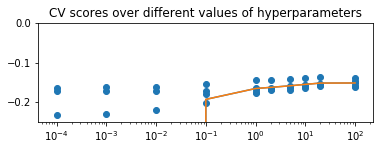

In [10]:
naiveallfit = df_filled_dummies.columns.tolist()
naiveallfit.remove(TARGET)
naiveallfit.remove(IDENTIFIER)

model,alpha_min = ridge_hyperparameter_tuning(df_filled_dummies,naiveallfit)
# Choose
print('Naive fit using 1-hot encoding, no preprocessing, on {} variables.\n->Hyperparameter:CV score is minimised using Ridge for alpha={}'.format(len(naiveallfit),alpha_min))
train_X, train_Y, test_X, test_ID, model,scores_log = training_model(df_filled_dummies,naiveallfit, model=model) 

 This approach yields a KAGGLE score: 0.15048  (approx. position 1300/1900)

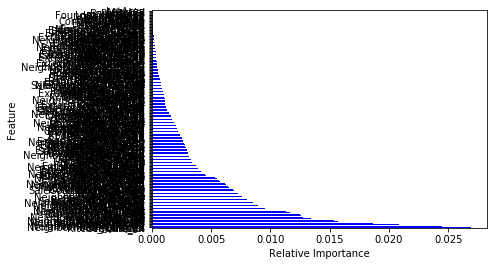

,Feature,Coeff
191,KitchenQual_Ex,10730.996362
63,BsmtQual_Ex,10593.245143
239,Neighborhood_NoRidge,9280.456969
240,Neighborhood_NridgHt,9139.096577


In [11]:
def feature_importance(train, model):
    """ create a dataframe with the correlation coefficients for each feature,
    then store the sign and the absolute value. Thus plot the absolute value
    using the sign as a color value to visualize the relative importance. """
    coeff_df = pd.concat([pd.Series(train.columns, name='Feature'),
                          pd.Series(model.coef_, name='Coeff')], axis=1)
    coeff_df['Positive'] = coeff_df['Coeff'] > 0
    coeff_df['Coeff_abs'] = coeff_df['Coeff'].abs()
    total_importance = coeff_df['Coeff_abs'].sum()
    coeff_df['Coeff_abs'] = coeff_df['Coeff_abs']/total_importance
    #coeff_df['Correlation'] = coeff_df['Correlation']/total_importance
    coeff_df = coeff_df.sort_values(by='Coeff_abs', ascending=False)
    coeff_df.plot(kind='barh', x='Feature', y='Coeff_abs', legend=False,
                  color=coeff_df["Positive"].map({True: 'b', False: 'r'}))
    plt.xlabel('Relative Importance')
    plt.show()
#    print(coeff_df)
    return coeff_df.drop(['Coeff_abs', 'Positive'], axis=1)
feature_weight = feature_importance(train_X, model)
feature_weight[1:5]

In [12]:
def submit_housing_prediction(test_id, Y_pred, filename):
    """ Prepare the solution in the format required by kaggle and write it to a file """
    # Sanity check: all prices positive
    if(np.sum(Y_pred<0)):
        print("NEGATIVE PRICES DETECTED! ABORTING!")
        return
    submission = pd.DataFrame({
        "Id": test_id,
        "SalePrice": Y_pred
        })
    submission.to_csv(filename, index=False)

# we predict
pred_Y = model.predict(test_X)

# write the prediction to file
filename = 'nonsense_submission.csv'
submit_housing_prediction(df_test["Id"], pred_Y, filename)
#  This gives a score of 0.15048 -> Very decent given that the features are nonsense

## Using the data description

Transform categorical variables that are actually of ordinal type to numbers.

In [13]:
# Change all quality feature to numerical
def to_ordinal(dfcol, ordered_list_of_values, meanfillNA=False):
    df = dfcol.map( {key:index for index, key in enumerate(ordered_list_of_values)})
    if meanfillNA: 
        df = df.fillna(df.mean())
    return df
b_fillNA = False
df_combined['BsmtExposure'] = to_ordinal(df_combined['BsmtExposure'],['NA','No', 'Mn', 'Av','Gd'],meanfillNA=b_fillNA)
df_combined['BsmtFinType1'] = to_ordinal(df_combined['BsmtFinType1'],['NA','Unf', 'LwQ', 'Rec','BLQ','ALQ','GLQ'],meanfillNA=b_fillNA)
df_combined['BsmtFinType2'] = to_ordinal(df_combined['BsmtFinType2'],['NA','Unf', 'LwQ', 'Rec','BLQ','ALQ','GLQ'],meanfillNA=b_fillNA)
df_combined['BsmtCond'] = to_ordinal(df_combined['BsmtCond'],['NA','Po', 'Fa', 'TA','Gd','Ex'],meanfillNA=b_fillNA)
df_combined['BsmtQual'] = to_ordinal(df_combined['BsmtQual'],['NA','Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)

df_combined['ExterQual'] = to_ordinal(df_combined['ExterQual'],['Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['ExterCond'] = to_ordinal(df_combined['ExterCond'],['Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['HeatingQC'] = to_ordinal(df_combined['HeatingQC'],['Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['KitchenQual'] = to_ordinal(df_combined['KitchenQual'],['Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['FireplaceQu'] = to_ordinal(df_combined['FireplaceQu'],['NA','Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['GarageFinish'] = to_ordinal(df_combined['GarageFinish'],['NA','Unf', 'RFn', 'Fin'],meanfillNA=b_fillNA)
df_combined['GarageQual'] = to_ordinal(df_combined['GarageQual'],['NA','Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['GarageCond'] = to_ordinal(df_combined['GarageCond'],['NA','Po', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['PoolQC'] = to_ordinal(df_combined['PoolQC'],['NA', 'Fa', 'TA','Gd', 'Ex'],meanfillNA=b_fillNA)
df_combined['Fence'] = to_ordinal(df_combined['Fence'],['NA', 'MnWw', 'GdWo','MnPrv', 'GdPrv'],meanfillNA=b_fillNA)

df_combined['CentralAir'] = to_ordinal(df_combined['CentralAir'],['N', 'Y'],meanfillNA=b_fillNA)

Separate numerical from categorical data and fill missing values

In [14]:
missing_data, numeric, categorical = examine_data(df_combined)

## EDA: Analyse numerical columns
Check their distributions, see what we can learn and (log)-normalize

In [15]:
# We start with a full set of columns and will gradually replace/refine
predictor_columns = numeric

### Incomplete columns

#### Analyze incomplete numerical columns, where the NA values are dropped

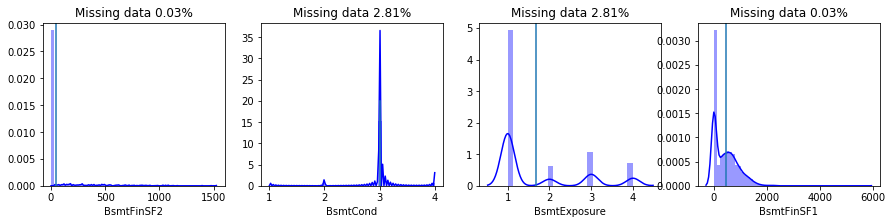

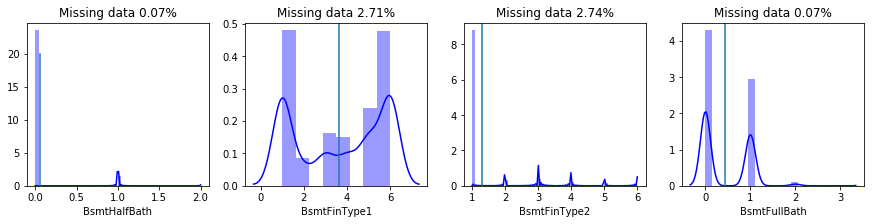

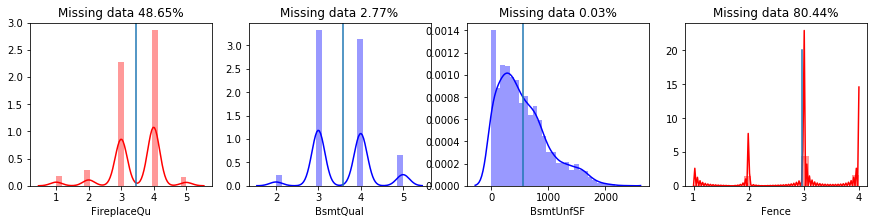

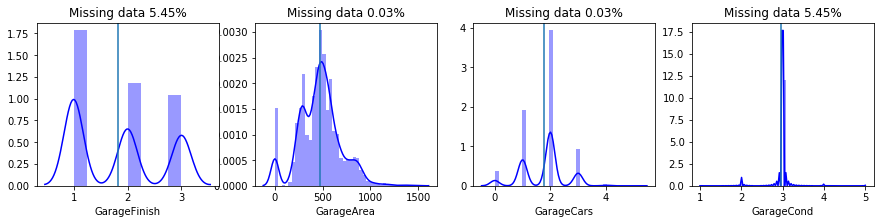

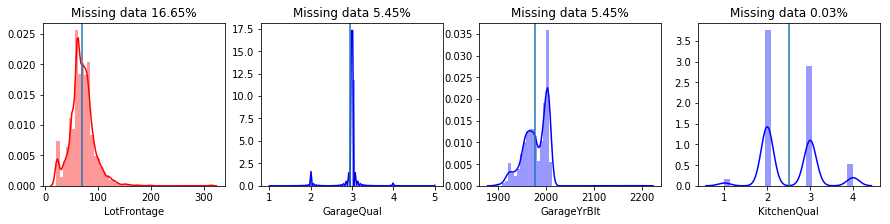

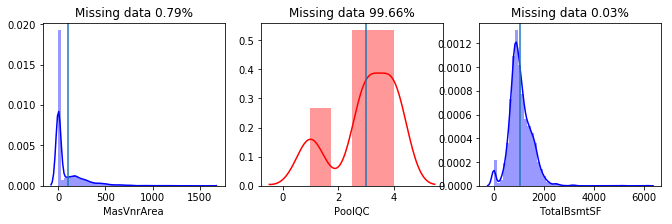

In [16]:
# If more then 10% is missing, plot is red. 
# Double lines help to identify if test set and training set follow the same distribution
j=1
for col in incomplete_columns:
    numcols = 4
    if col in numeric:
        if(j%numcols==1):
            fig=plt.figure(figsize=(15, 3))
        ax = fig.add_subplot(1,numcols,j%numcols+1)
        color = 'b'
        if missing_data[col]>0.10:
            color = 'r'
        sns.distplot(df_combined[col].dropna(),color=color)
        #sns.distplot(df_test[col].dropna(),color='g')
        plt.plot([df_combined[col].dropna().mean()]*2,[0,20])
        ax.set_title('Missing data {:1.2f}%'.format((missing_data[col]*100)))
        j+=1

This suggests the we can use mean values for all variables but
before we decide this and wether to drop columns with too many missing values, we plot them against the target

In [17]:
def plot_dist_vs_logdist(df, column, bins=100, normalize = False, 
                         oneplus=False, remove_zeros=False):
    data    = df[column]
    if remove_zeros:
        data = df[(data!=0)][column]     
    
    # Remove NaN before proceeding
    data = np.array(list(filter(lambda v: v==v, data)))
    
    if oneplus:
        logdata = np.log(1+data)
    else:
        logdata = np.log(data)
    
    if normalize:
        data    = preprocessing.scale(data)
        logdata = preprocessing.scale(logdata)
    
    fig = plt.figure(figsize=(15, 3))
    ax1 = fig.add_subplot(121)
    sns.distplot(data,bins=bins,fit=stats.norm).set_title('Actual distr.')
    ax2 = fig.add_subplot(122)
    sns.distplot(logdata,bins=bins,fit=stats.norm).set_title('Distr. of log')
    ax1.set(xlabel=column)
    ax1.legend(['data','normal fit'])

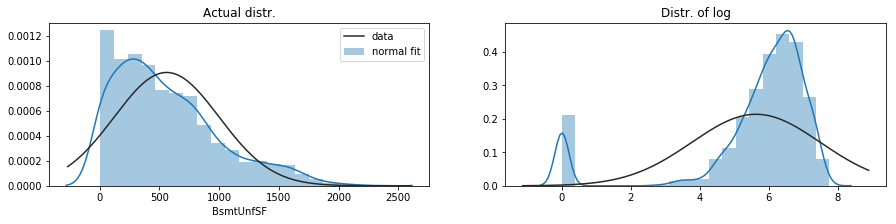

In [18]:
# For curiosity, check if BsmtUnfSF is lognormal 
plot_dist_vs_logdist(df_combined, 'BsmtUnfSF',normalize=False,bins=20, oneplus=True)

#### Quality control of filling values and Outlier detection

First definition of outlier: Just visual

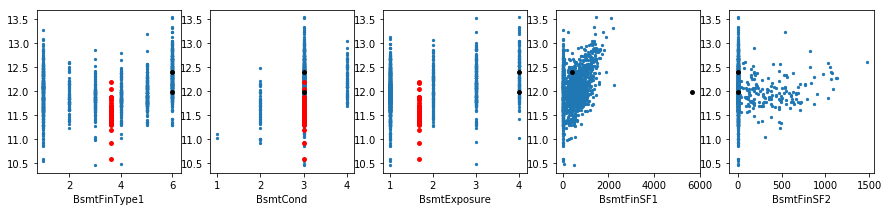

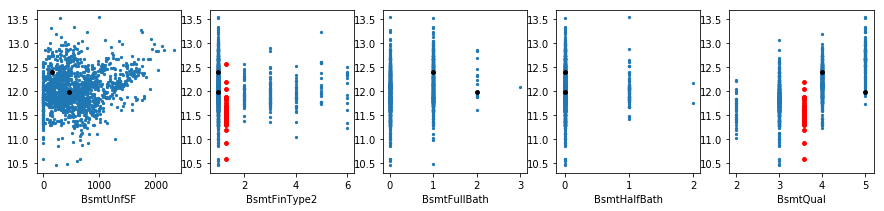

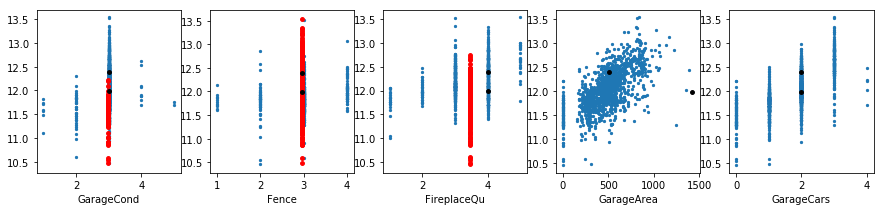

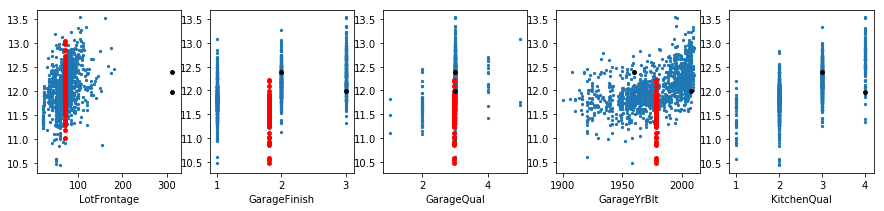

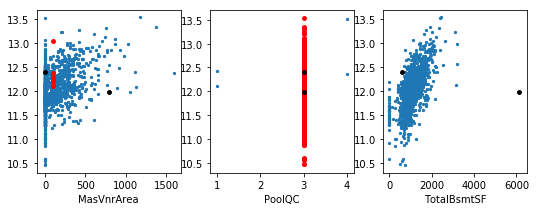

In [19]:
# Check dependence: numerical variables vs log(price) [red: missing data]
# In red, we see the missing data points (to check if they are outliers), we use the mean for them
# If there are no red points, then missing values are in test set
j=1
df_train,df_test =split_data(df_combined)

df_filled = fill_missing_values(df_combined, numeric, lambda x : x.mean(), inplace=False)
df_train_filled,_=split_data(df_filled)

outl_indices=(df_train['TotalBsmtSF']>5000) | (df_train['LotFrontage']>200)
#four_garages=(df_train['GarageCars']>3)
for col in incomplete_columns:
    if col in numeric:
        if(j%5==1):
            fig=plt.figure(figsize=(15, 3))
        fig.add_subplot(1,5,j%5+1)
        
        df_no_na   = df_train[[col,'SalePrice']].dropna()
        na_indices = df_train[col].isnull()
        plt.scatter(df_no_na[col],np.log(df_no_na['SalePrice']),s=5)
        plt.scatter(df_train_filled[na_indices][col],np.log(df_train_filled[na_indices]['SalePrice']),color='r',s=15)
        plt.scatter(df_train_filled[outl_indices][col],np.log(df_train_filled[outl_indices]['SalePrice']),color='k',s=15)
        #plt.scatter(df_train_filled[four_garages][col],np.log(df_train_filled[four_garages]['SalePrice']),color='y',s=15)
        plt.xlabel(col)
        j+=1

__Conclusions__: 

_GarageYearBuilt_: Missing value seems to be an indicator that the value is on the low side.
Could add a variable, but that might be overfitting.

Other variables deal well with missing values (not many anyway)

Also, we drop the columns with too much missing data, such as PoolQC

__Outliers__:
Big places at medium prices, two seamingly different properties.
1 has a huge basement and huge front, the other just a huge front.

Store for now in outl_indices

In [20]:
if 'PoolQC' in predictor_columns:
    predictor_columns.remove('PoolQC')
if 'Fence' in predictor_columns:
    predictor_columns.remove('Fence')
if 'FireplaceQu' in predictor_columns:
    predictor_columns.remove('FireplaceQu')

    
## ASSUMPTIONS:
# Missing data for BsmtQual means no basement
fill_missing_values(df_combined, ['BsmtQual'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['BsmtExposure'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['BsmtFinType1'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['BsmtFinType2'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['BsmtCond'], lambda x : 0, inplace=True)

# Missing ... for GarageCond means no Garage
fill_missing_values(df_combined, ['GarageCond'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['GarageFinish'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['GarageQual'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['GarageCond'], lambda x : 0, inplace=True)
fill_missing_values(df_combined, ['GarageYrBlt'], lambda x : 1920, inplace=True)

# For the others, just use the mean values
fill_missing_values(df_combined, numeric, lambda x : np.mean(x), inplace=True)

print('df_combined[predictor_columns] has been filled and overwritten!')
# Probably it is enough to use number of garages

df_combined[predictor_columns] has been filled and overwritten!


### Complete columns

#### Check target variable: we notice that it is close to log-normal distributed. 
Add variable: 'logPrice'

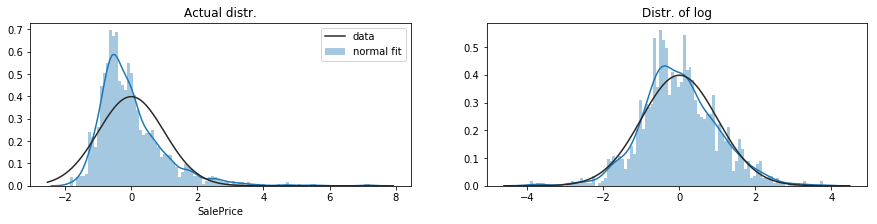

In [21]:
# Illustrate lognormal distribution
plot_dist_vs_logdist(df_train, 'SalePrice',normalize=True,bins=100)

In [22]:
# Add new target column
df_combined['logPrice'] = np.log(df_combined['SalePrice'])

#### Examine distributions of complete columns. 
Test and train are sufficiently close for us to assume they are drawn from the same population

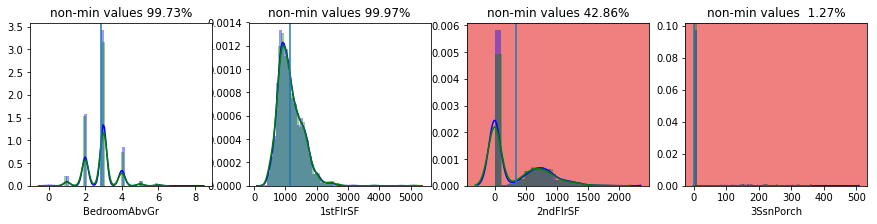

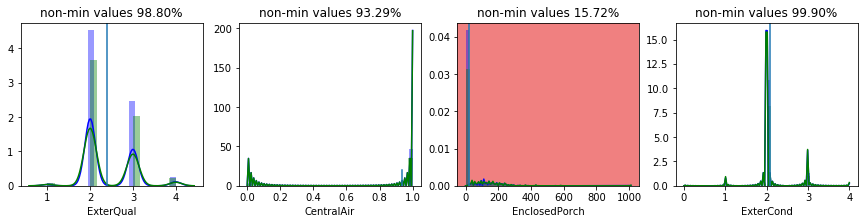

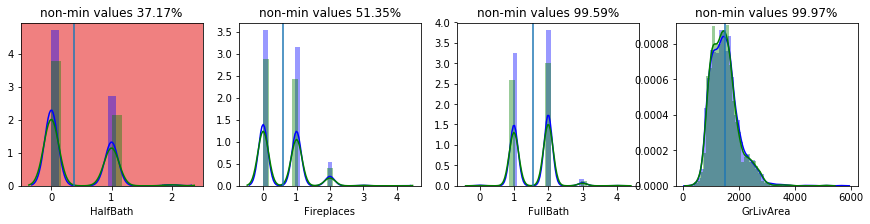

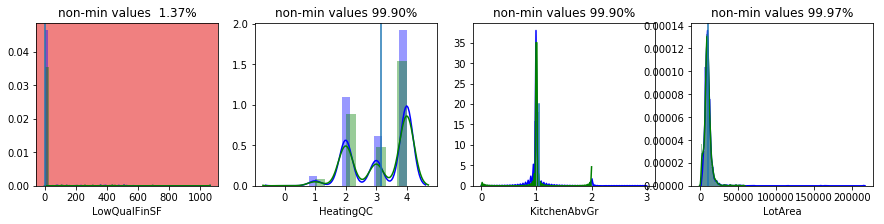

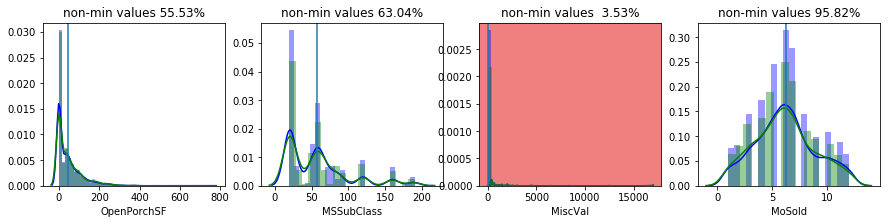

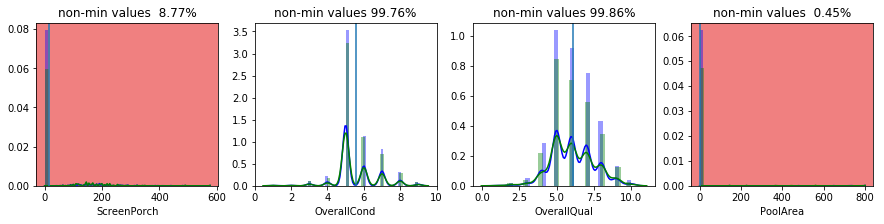

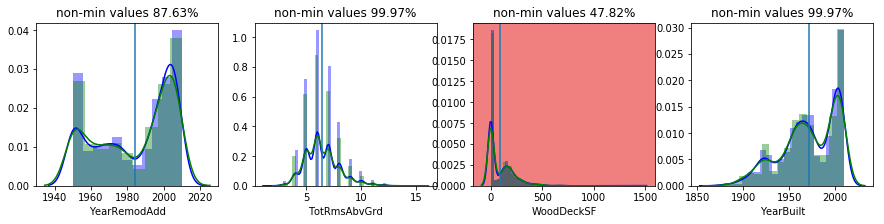

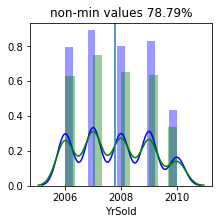

In [23]:
# Double lines help to identify if test set and training set follow the same distribution (red:>50% takes min val)
# We highlight in red the variables which take the minimal value in more than 50% of data
j=1
underdetermined_data = {}
for col in complete_columns:
    numcols = 4
    if col in numeric:
        if col=='Id':
            continue
        if(j%numcols==1):
            fig=plt.figure(figsize=(15, 3))
        ax = fig.add_subplot(1,numcols,j%numcols+1)
        # Find min values
        nr_items       = len(df_combined[col].dropna())
        min_value      = min(df_combined[col])
        min_percentage = 100*(df_combined[col]==min_value).sum()/nr_items
        ax.set_title('non-min values {:5.2f}%'.format((100-min_percentage)))
        
        if min_percentage > 50:
            ax.set_axis_bgcolor('lightcoral')
            underdetermined_data[col] = min_percentage/100
            
        sns.distplot(df_combined[col].dropna(),color='b')
        sns.distplot(df_test[col].dropna(),color='g')
        
        plt.plot([df_combined[col].dropna().mean()]*2,[0,20])
        j+=1

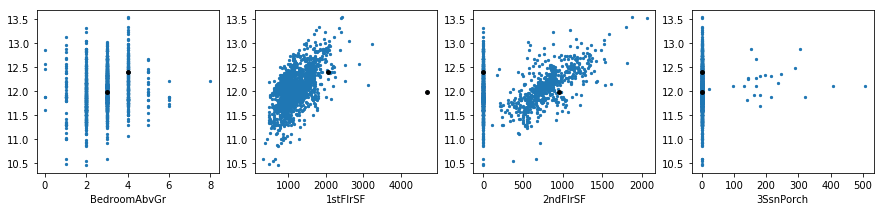

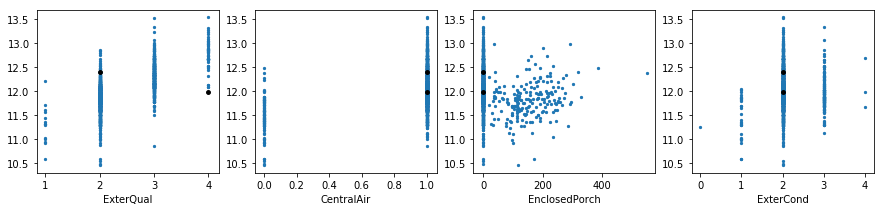

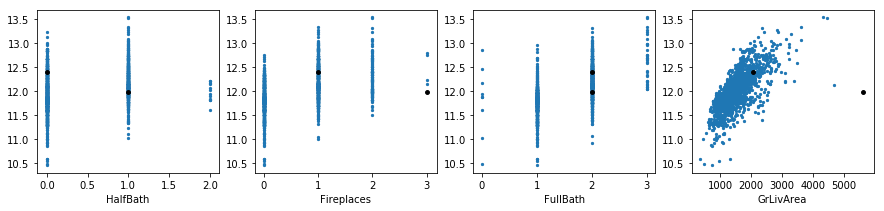

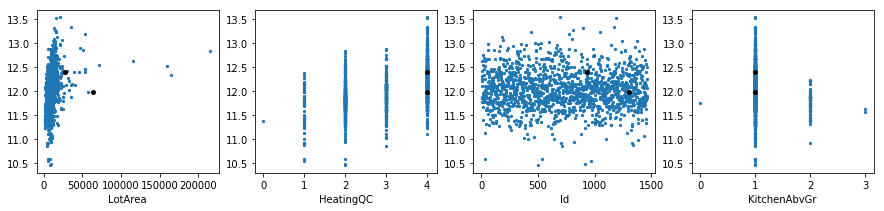

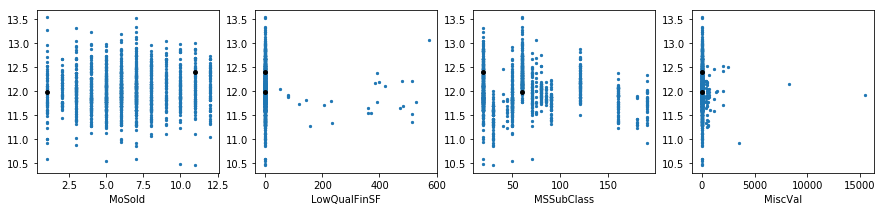

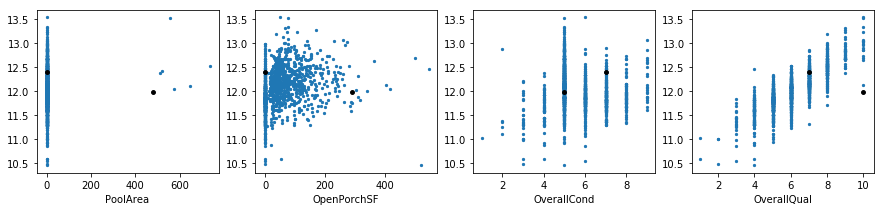

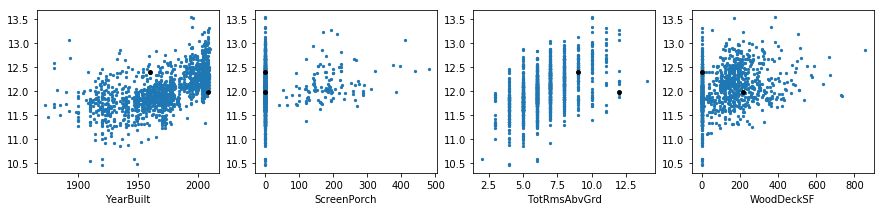

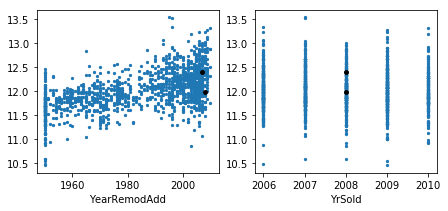

In [24]:
# Check dependence: complete numerical variables vs log(price)
j=1
df_train,df_test =split_data(df_combined)
df_train_filled,_=split_data(df_filled)

outl_indices=(df_train['TotalBsmtSF']>5000) | (df_train['LotFrontage']>200)
#four_garages=(df_train['GarageCars']>3)
for col in complete_columns:
    numcols = 4
    if col in numeric:
        if(j%numcols==1):
            fig=plt.figure(figsize=(15, 3))
        fig.add_subplot(1,numcols,j%numcols+1)
        
        df_no_na   = df_train[[col,'SalePrice']].dropna()
        na_indices = df_train[col].isnull()
        
        plt.scatter(df_no_na[col],np.log(df_no_na['SalePrice']),s=5)
        plt.scatter(df_train_filled[outl_indices][col],np.log(df_train_filled[outl_indices]['SalePrice']),color='k',s=15)
        #plt.scatter(df_train_filled[four_garages][col],np.log(df_train_filled[four_garages]['SalePrice']),color='y',s=15)
        plt.xlabel(col)
        j+=1

In [25]:
# Share of data points that have value 0 in the category:
underdetermined_data

{'2ndFlrSF': 0.57142857142857151,
 '3SsnPorch': 0.98732442617334693,
 'EnclosedPorch': 0.84275436793422398,
 'HalfBath': 0.62829736211031173,
 'LowQualFinSF': 0.98629667694415901,
 'MiscVal': 0.96471394313120928,
 'PoolArea': 0.99554642000685167,
 'ScreenPorch': 0.91229873244261739,
 'WoodDeckSF': 0.52175402535114768}

We suspect that '1stFlrSF', 'LotArea' are (a tad) better suited to a log-normal distr. For LotArea, at least we smoothen the outlier a bit

Note that LowQualFinSF has 98% non-min value! We remove it from the predictors.

__And we add columns with the log(data)__

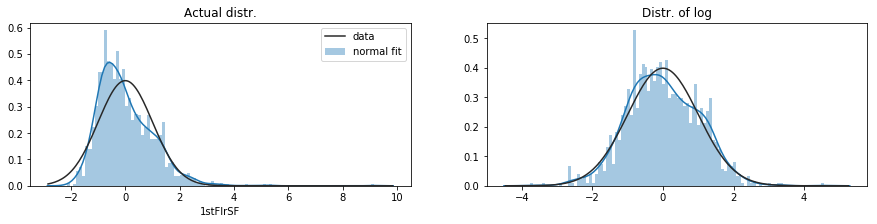

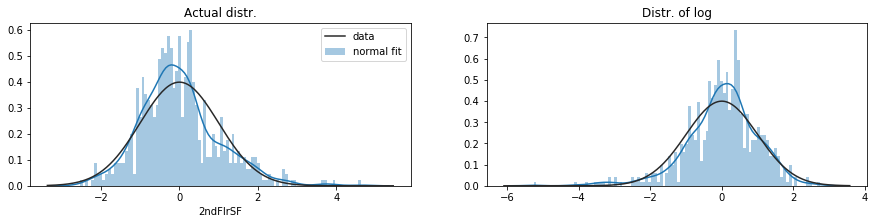

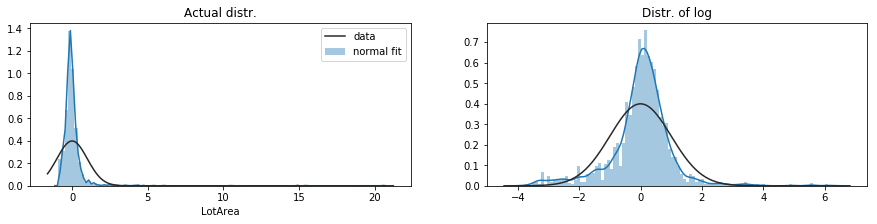

In [26]:
plot_dist_vs_logdist(df_train, '1stFlrSF',normalize=True, bins=100)
plot_dist_vs_logdist(df_train, '2ndFlrSF',normalize=True, bins=100,remove_zeros=True)
plot_dist_vs_logdist(df_train, 'LotArea' ,normalize=True, bins=100,oneplus=True)

Generate new features (log of data) and identify new outliers
(notice that some are possibly in the test data!)

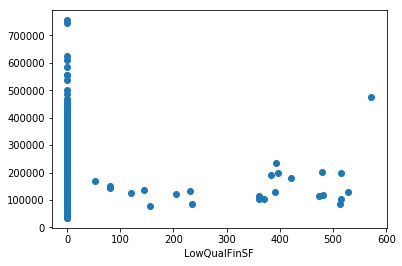

In [27]:
df_combined['log1stFlrSF']     = preprocessing.scale(np.log(df_combined['1stFlrSF']))
df_combined['log2ndFlrSF']     = preprocessing.scale(np.log(1+df_combined['2ndFlrSF']))
df_combined['logLotArea']      = preprocessing.scale(np.log(df_combined['LotArea']))

# Since there are not many data points, and they lie in a similar price range
# Except for outliers, which we identify from scatter plot
df_combined['hasLowQualFinSF'] = df_combined['LowQualFinSF'].apply(lambda x: 1 if x>0 else 0)

# Update predictor variables
predictor_columns += ['log1stFlrSF', 'log2ndFlrSF', 'logLotArea', 'hasLowQualFinSF']
if '1StFlrSF' in predictor_columns:
    predictor_columns.remove('1StFlrSF')
if '2ndFlrSF' in predictor_columns:
    predictor_columns.remove('2ndFlrSF')
if 'LotArea' in predictor_columns:
    predictor_columns.remove('LotArea')
if 'LowQualFinSF' in predictor_columns:
    predictor_columns.remove('LowQualFinSF')


# Add very large SF to outlier indices
plt.scatter(df_filled['LowQualFinSF'],df_filled['SalePrice'])
plt.xlabel('LowQualFinSF')

outl_indices = outl_indices | (df_combined['LowQualFinSF']>550)

#### Check dependence: numerical variables vs log(price)

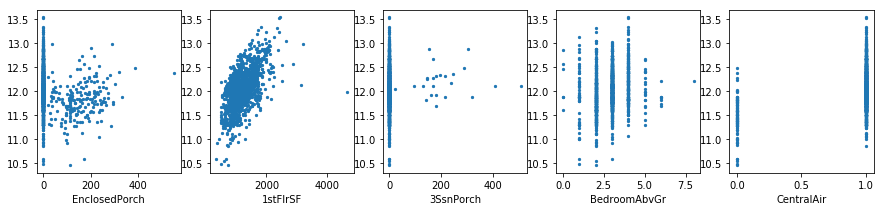

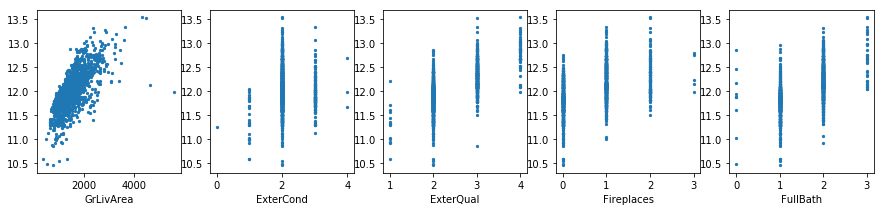

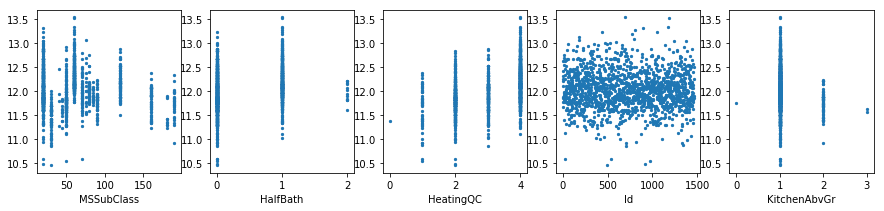

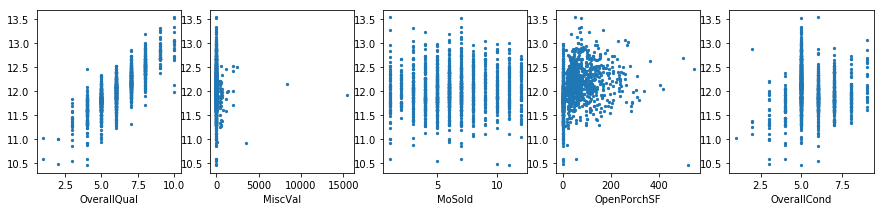

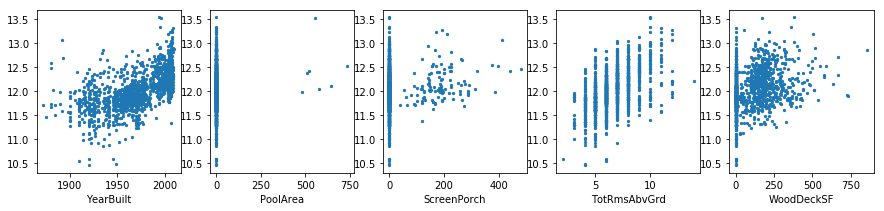

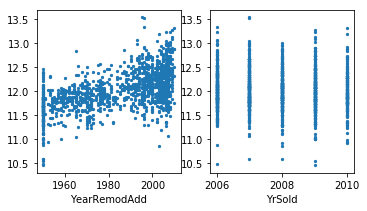

In [28]:
j=1
df_train_filled, _ = split_data(df_combined)
for col in complete_columns:
    if col in predictor_columns:
        if(j%5==1):
            fig=plt.figure(figsize=(15, 3))
        fig.add_subplot(1,5,j%5+1)
        
        df_no_na   = df_train[[col,'SalePrice']].dropna()
        na_indices = df_train[col].isnull()
        plt.scatter(df_no_na[col],np.log(df_no_na['SalePrice']),s=5)
        plt.scatter(df_train_filled[na_indices][col],np.log(df_train_filled[na_indices]['SalePrice']),color='r',s=5)
        #plt.scatter(df_train_filled[outl_indices][col],np.log(df_train_filled[outl_indices]['SalePrice']),color='k',s=15)
        #plt.scatter(df_train_filled[four_garages][col],np.log(df_train_filled[four_garages]['SalePrice']),color='y',s=15)
        plt.xlabel(col)
        j+=1

We dont notice anything extraordinary, except that
3SSNPorch has not much significant value. We drop it.
Month-sold might be useless too.
We keep misc-value for common sense reasoning.

In [29]:
if '3SsnPorch' in predictor_columns:
    predictor_columns.remove('3SsnPorch')

#### __What have we done so far:__

We have examined the data, filled in missing values, log-transformed 3 columns


<font color=red>__What is missing:__</font>
We should introduce a few binary variables and discard the corresponding columns when there is not much data available

## EDA Categorical variables

### Incomplete columns

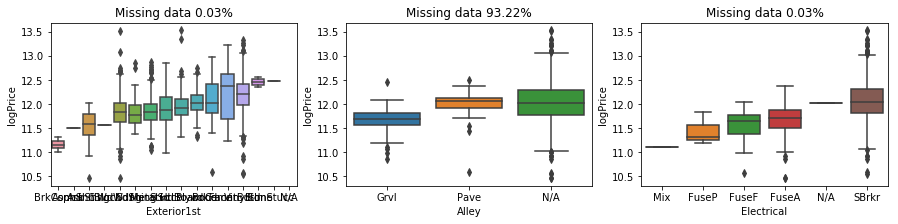

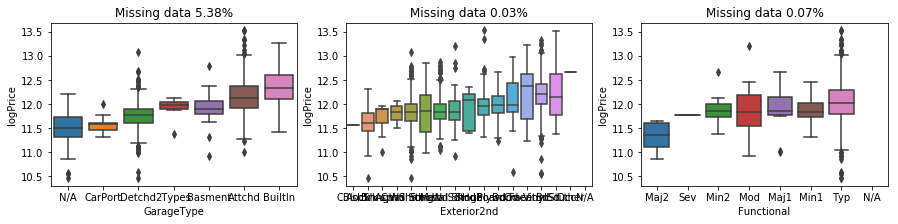

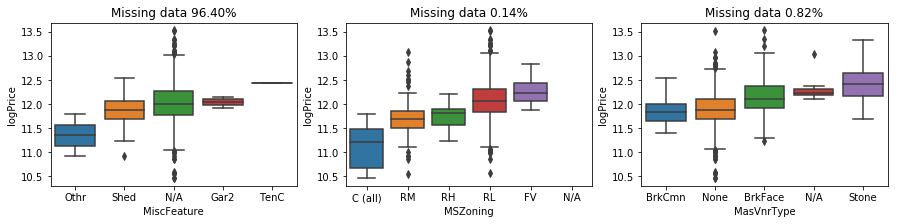

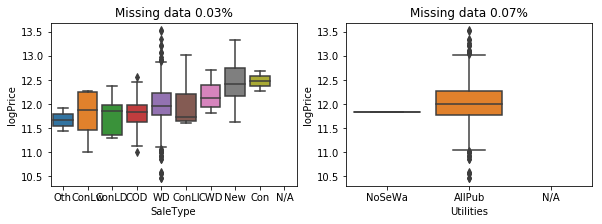

In [30]:
# First visualization
j=1
df_cat = df_combined.copy()
incomplete_categorical = []
for col in incomplete_columns:
    numcols = 3 # columns of plot
    if col in categorical:
        incomplete_categorical += [col]
        df_cat[col] = df_cat[col].fillna('N/A')
        if(j%numcols==1):
            fig=plt.figure(figsize=(15, 3))
        ax = fig.add_subplot(1,numcols,j%numcols+1)
        color = 'b'
        if missing_data[col]>0.10:
            color = 'r'
        # Sort categories by mean
        tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
        order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
        fig.add_subplot(1,numcols,j%numcols+1)
        sns.boxplot(x=col,y='logPrice',data=df_cat,order=order)
        #plt.scatter(df_cat[col],df_cat['logPrice'])
        ax.set_title('Missing data {:1.2f}%'.format((missing_data[col]*100)))
        j+=1

Alley has too much missing data: drop
Same holds for Misc Feature. 
AllPub essentially only takes 1 value: drop.

From this plot, we decide to make some variables ordinal.

In [31]:
incomplete_categorical

['Alley',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Functional',
 'GarageType',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'SaleType',
 'Utilities']

##### Electrical (will be modal filled and converted to ordinal)

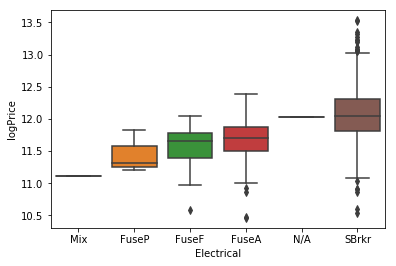

In [32]:
col = 'Electrical'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [33]:
# Add to predictors
if col not in predictor_columns:
    df_combined[col]   = to_ordinal(df_combined[col],['Mix','FuseP', 'FuseF','FuseA','SBrkr'],meanfillNA=True)
    predictor_columns += [col]

##### Exterior1st & 2nd ( create two subgroups: high value and low value: notice that there are bad outliers, so maybe not ideal ) 
Reason is that there is a lot of variance seen in the plot.
Actually we ignore the 2nd floor since it is almost the same

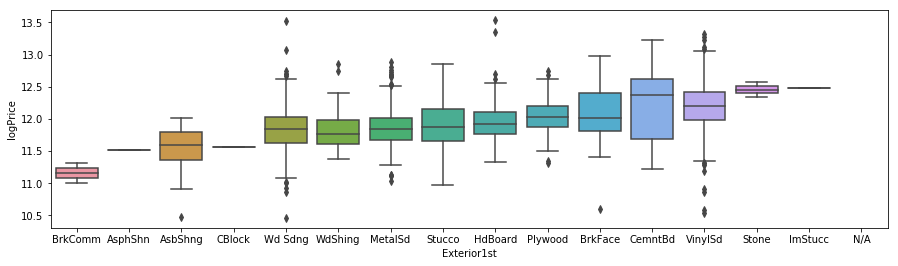

In [34]:
col = 'Exterior1st'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 4)
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

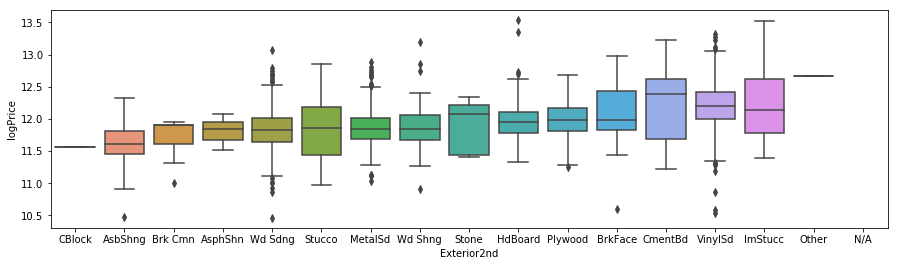

In [35]:
col = 'Exterior2nd'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 4)
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [57]:
# Add to predictors
col = 'badExterior1st'
if col not in predictor_columns:
    df_combined[col]   = df_combined[ 'Exterior1st'].map({ k:1 for k in ['BrkComm', 'AshphShn', 'AsbShng', 'CBlock']}).fillna(0)
    predictor_columns += [col]
col = 'goodExterior1st'
if col not in predictor_columns:
    df_combined[col]   = df_combined[ 'Exterior1st'].map({ k:1 for k in ['BrkFace', 'CemntBd', 'Sone', 'ImStucc']}).fillna(0)
    predictor_columns += [col]

#### Sale type -> ordinal

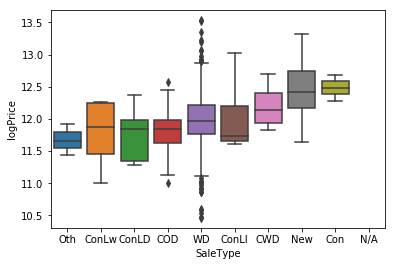

In [37]:
col = 'SaleType'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [38]:
# Add to predictors
if col not in predictor_columns:
    df_combined[col]   = to_ordinal(df_combined[col],['Oth','ConLw', 'ConLD','COD','WD', 'ConLi', 'VWD', 'CWD', 'New', 'Con'],meanfillNA=True)
    predictor_columns += [col]

#### MSZoning  -> ordinal

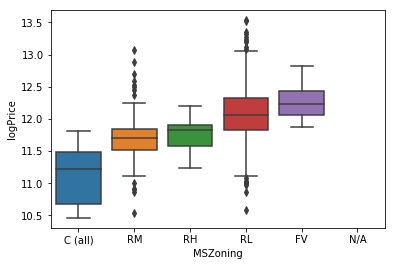

In [39]:
col = 'MSZoning'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [40]:
# Add to predictors
if col not in predictor_columns:
    df_combined[col]   = to_ordinal(df_combined[col],['C (all)','RM', 'RH','RL','FV'],meanfillNA=True)
    predictor_columns += [col]

#### Functional (only use as hasDeductions )

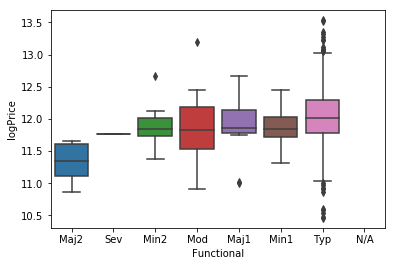

In [41]:
col = 'Functional'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [42]:
# Add to predictors
col = 'hasDeductions'
if col not in predictor_columns:
    df_combined[col]   = list(map(lambda x: 0 if x=='Typ' else 1, df_combined['Functional']))
    predictor_columns += [col]

#### MasVnrType

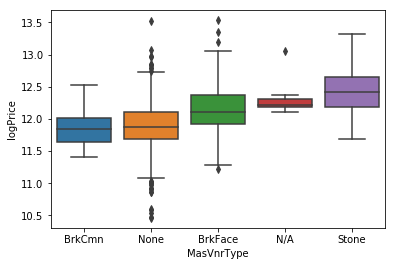

In [43]:
col = 'MasVnrType'
tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
sns.boxplot(x=col, y='logPrice', data=df_cat,order=order)

In [44]:
# Add to predictors
if col not in predictor_columns:
    df_combined[col]   = to_ordinal(df_combined[col],['BrkCmn', 'None', 'BrkFace', 'N/A', 'Stone'],meanfillNA=True)
    predictor_columns += [col]

### Analyze complete categorical columns

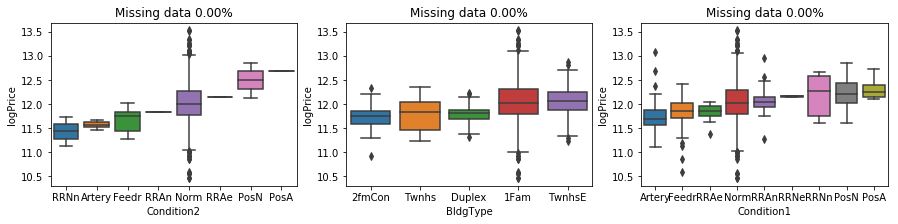

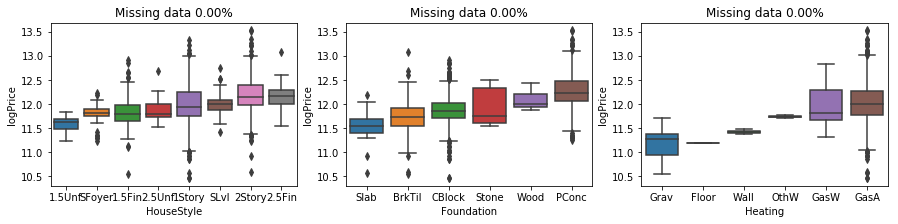

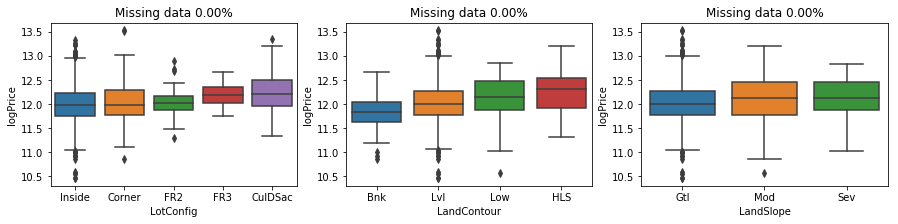

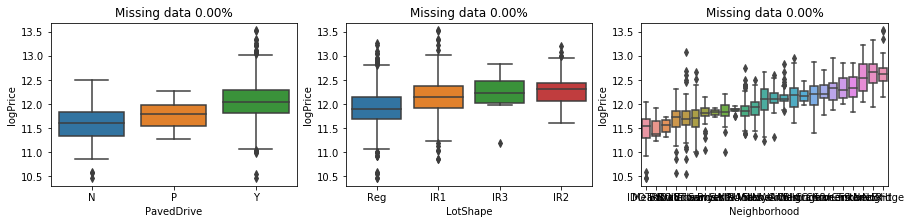

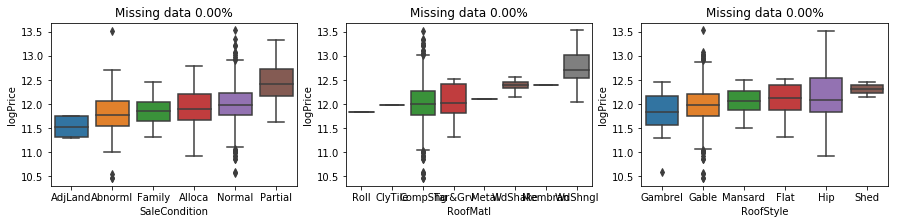

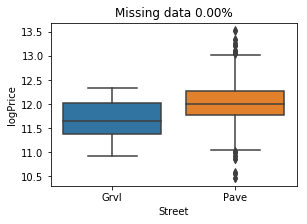

In [45]:
# Sort all variables and use in ordinal shape
j=1
df_cat = df_combined.copy()
complete_categorical = []
for col in complete_columns:
    numcols = 3 # columns of plot
    if col in categorical:
        complete_categorical += [col]
        df_cat[col] = df_cat[col].fillna('N/A')
        if(j%numcols==1):
            fig=plt.figure(figsize=(15, 3))
        ax = fig.add_subplot(1,numcols,j%numcols+1)
        color = 'b'
        if missing_data[col]>0.10:
            color = 'r'
        # Sort categories by mean
        tmpgrouped = df_cat[[col,'logPrice']].groupby(col).mean()
        order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('logPrice')[col].tolist()
        fig.add_subplot(1,numcols,j%numcols+1)
        sns.boxplot(x=col,y='logPrice',data=df_cat,order=order)
        #plt.scatter(df_cat[col],df_cat['logPrice'])
        ax.set_title('Missing data {:1.2f}%'.format((missing_data[col]*100)))
        j+=1
        # Convert to ordinal
        if col not in predictor_columns:
            df_combined[col]   = to_ordinal(df_combined[col],order)
            predictor_columns += [col]
        

# Predict

In [59]:
df_combined[predictor_columns].isnull().any().any()

False

In [46]:
nonoutl_indices =(df_combined['GrLivArea']<4000) | (df_combined['SalePrice']>300000)

Educated fit using ordinal scaling from above and mean filling on 73 variables.
->Hyperparameter:CV score is minimised using Ridge for alpha=20
Training set:  (1458, 75) Test set: (1459, 75)
k-fold cross validation score = -0.116 ; -0.102 ; -0.124 ; -0.128 ; -0.102 ; -0.119 ; -0.101 ; -0.114 ; 
Worst score = -0.128, Mean score = -0.113, Std deviation = 0.010
Variance (R^2) score: 0.93


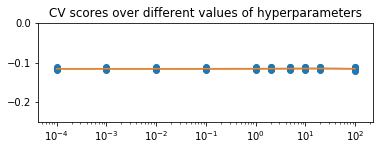

In [60]:
educatedfit = predictor_columns
#educatedfit.remove(IDENTIFIER)
# remove outliers
df = df_combined[ (nonoutl_indices) | (df_combined['logPrice'].isnull())]
# NORMALIZING WILL NOT HAVE AN EFFECT (it is even worse after 3 digits!)
modelfunction = lambda x : linear_model.Ridge (alpha = x,normalize=False, max_iter=1e5)
model,alpha_min = ridge_hyperparameter_tuning(df,educatedfit,predictinglog=True, parametrized_model = modelfunction, target='logPrice')
# Choose
print('Educated fit using ordinal scaling from above and mean filling on {} variables.\n->Hyperparameter:CV score is minimised using Ridge for alpha={}'.format(len(educatedfit),alpha_min))
train_X, train_Y, test_X, test_ID, model,scores_log = training_model(df,educatedfit, predictinglog=True,model=model, target='logPrice') 
#[1e-4, 1e-3,1e-2, .1, 1,2, 5, 10, 20,100]


In [ ]:
# we predict
pred_Y = model.predict(test_X)
pred_Y = np.exp(pred_Y)
# write the prediction to file
filename = 'first_submission1_outliers_out.csv'
submit_housing_prediction(df_test["Id"], pred_Y, filename)

# Old
We see that some variables have many 0 values, which means we will introduce a new variable: "has_property".

This holds for 
["WoodDeckSF" "OpenPorchSF", "EnclosedPorch", "2ndFloorSF", "PoolArea"]

In [ ]:
df_combined["hasWoodDeck"]=list(map(lambda x: 1 if x else 0,df_combined["WoodDeckSF"]>0))
df_combined["hasOpenPorch"]=list(map(lambda x: 1 if x else 0,df_combined["OpenPorchSF"]>0))
df_combined["hasEnclosedPorch"]=list(map(lambda x: 1 if x else 0,df_combined["EnclosedPorch"]>0))
df_combined["has2ndFloor"]=list(map(lambda x: 1 if x else 0,df_combined["2ndFlrSF"]>0))
df_combined["hasPool"]=list(map(lambda x: 1 if x else 0,df_combined["PoolArea"]>0))
df_combined["has3SsnPorch"]=list(map(lambda x: 1 if x else 0,df_combined["3SsnPorch"]>0))
df_combined["hasScreenPorch"]=list(map(lambda x: 1 if x else 0,df_combined["ScreenPorch"]>0))


# How many pools
print("WDecks: {:.3}% ".format(df_combined["hasWoodDeck"].sum()/df_combined.shape[0]))
print("OPorch: {:.3}%".format(df_combined["hasOpenPorch"].sum()/df_combined.shape[0]))
print("EPorch: {:.3}%".format(df_combined["hasEnclosedPorch"].sum()/df_combined.shape[0]))
print("2ndFlr: {:.3}%".format(df_combined["has2ndFloor"].sum()/df_combined.shape[0]))
print("Pools: {:.3}%".format(df_combined["hasPool"].sum()/df_combined.shape[0]))
print("3SsnPorch: {:.3}%".format(df_combined["has3SsnPorch"].sum()/df_combined.shape[0]))
print("ScreenPorch: {:.3}%".format(df_combined["hasScreenPorch"].sum()/df_combined.shape[0]))


## EDA: Categorical data
For now, lets use GrLivArea, [not bc only 2% of rows] has3SSnPorch, log(LotArea), OverallQual  

but we examine other non-numerical values first

In [ ]:
# Have a look at how much missing data we have
print(df_combined.drop(complete_numeric_columns,axis=1).count().sort_values()/len(df_combined.index))

In [ ]:
# use complete columns first
complete_cat_columns=df_combined[complete_columns].drop(complete_numeric_columns,axis=1).columns
df_combined[complete_cat_columns].describe()
#Check direct influence on log-target
j=1
for col in complete_cat_columns.tolist():
    figs_per_row = 3
    if(j%figs_per_row==1):
        fig=plt.figure(figsize=(18, 3))
    # Sort categories by mean
    tmpgrouped = df_combined[[col,'LogPrice']].groupby(col).mean()
    order      = pd.DataFrame(tmpgrouped).reset_index().sort_values('LogPrice')[col].tolist()
    fig.add_subplot(1,figs_per_row,j%figs_per_row+1)
    sns.boxplot(x=col,y='LogPrice',data=df_combined,order=order)
    j+=1

From these plots, we learn that some categories are important as expected, such as Neighborhood but also others.
I propose to combine categorical values to reduce the dimensionality and avoid overfitting.

For example:
Heating: if there is Grav heating, it is bad: so hasGrav, if it has GasW, it is above avg
Street: Grvl indicates lower prices

In [ ]:
mapper = { val:0 for val in df_combined["Heating"].unique()}
mapper['Grav']=1
df_combined["hasGrav"] = df_combined["Heating"].map(mapper)
mapper = { val:0 for val in df_combined["Heating"].unique()}
mapper['GasW']=1
df_combined["hasGasW"] = df_combined["Heating"].map(mapper)

df_combined["hasGrvl"] = df_combined["Street"].map({'Grvl':1, 'Pave':0})
# Exterior quality has linear tendence, so add numerical values, the N indicates that it has been digitised
df_combined["NExterQual"] =  df_combined["ExterQual"].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3,'Ex':4})

df_combined['hasCentralAir']=df_combined["CentralAir"].map({'Y':1, 'N':0})

In [ ]:
plt.figure(figsize=(18, 3))
tmpgrouped = df_combined[['Neighborhood','LogPrice']].groupby('Neighborhood').mean()
neighborhoodorder      = pd.DataFrame(tmpgrouped).reset_index().sort_values('LogPrice')['Neighborhood'].tolist()
    
sns.boxplot(x='Neighborhood',y='LogPrice',data=df_combined,order=neighborhoodorder)
Nneighborhoodorder={val:key for key,val in enumerate(neighborhoodorder)}
df_combined['NNeighborhood'] = df_combined['Neighborhood'].map(Nneighborhoodorder)
# We could closely examine old town, where there is a lot of variance
# An idea is to combine the isOldTown with other models!
# The same holds for normal condition1 !!

In [ ]:
# USE WHAT WE HAVE SO FAR:
variables_secondfit = ['GrLivArea', 'LogLotArea', 
                      'NNeighborhood','NExterQual','hasGasW','hasGrav','hasGrvl',
                      'hasScreenPorch', 'hasCentralAir']
# Scale what we can preprocessing.scale(df_combined['hasScreenPorch']
# WE ALSO PREDICT THE LOG PRICE!! NOTICE THAT WE HAVE TO EXPONENTIATE AFTER
df_combined2=df_combined.copy()
df_combined2[variables_secondfit] = preprocessing.scale(df_combined2[variables_secondfit])
train_X, train_Y, test_X, test_ID, model,scores_log = training_model(df_combined,variables_secondfit,target='LogPrice',predictinglog=True)


# we predict
pred_Y = np.exp(model.predict(test_X))

# print the prediction
filename = 'second_submission.csv'
submit_housing_prediction(df_test["Id"], pred_Y, filename)

In [ ]:
# Quality variables
BsmtCond,BsmtFinSF1,BsmtFinSF2,ExterCond

In [ ]:
['BldgType', BsmtExposure,Alley,CentralAir,
 BsmtUnfSF,Electrical,EnclosedPorch,Exterior

In [ ]:
# Location variables
Condition1,Condition2

## SWITCH

In [ ]:
def add_switch(df, columns, filter= lambda x: 1 if x.notnull() else 0,
                            dependence=lambda x,y: x*y, inplace=False):
    for col in columns:
        df[col+'_switch'] = filter(df[col])
    return 
dff = df_train[['hasBsmtFinSF1','BsmtFinSF1','SalePrice']]

dff['SalePrice'] = np.log(df_train['SalePrice'])
#dff['BsmtFinSF1']= (dff['BsmtFinSF1'])
plt.scatter(dff[['BsmtFinSF1']],dff['SalePrice'])

#model = LinearRegression(fit_intercept=True, normalize=False)
#model.fit(dff[['BsmtFinSF1']], dff['SalePrice'])
#plt.plot(dff['BsmtFinSF1'],model.predict(dff[['BsmtFinSF1']]),color='g')

#dff['hasBsmtFinSF1'] = dff['BsmtFinSF1'].apply(lambda x: 1 if x>0 else 0)
#model = LinearRegression(fit_intercept=True, normalize=False)
#model.fit(dff[['hasBsmtFinSF1','BsmtFinSF1']],dff['SalePrice'])
#plt.scatter(dff['BsmtFinSF1'],model.predict(df_train[['hasBsmtFinSF1','BsmtFinSF1']]),color='r')

# Subselection
dff = dff[dff['hasBsmtFinSF1']==1]
model.fit(dff[['hasBsmtFinSF1','BsmtFinSF1']],dff['SalePrice'])
#plt.plot(dff['BsmtFinSF1'],model.predict(dff[['hasBsmtFinSF1','BsmtFinSF1']]),color='y')
#plt.ylim([0,600000])

#df_train[df_train['hasBsmtFinSF1']==0]['SalePrice'].hist(bins=100)
plt.clf()
sns.distplot((dff['BsmtFinSF1'].dropna()))


### Prediction

With this model we got a LeaderBoard score of $0.357$. Very bad.

# Explore other models & Ensembling (not done)